In [ ]:
"""
Merge normalized telemetry and track geometry CSVs in NewData/.
Outputs per-track merged CSVs and a combined merged_train.csv in NewData/.

Behavior:
- Finds telemetry files matching '*_data_normalized.csv' and track geometry files matching '*_with_boundaries_normalized.csv'
- Matches telemetry -> track by Track column or filename heuristics
- Builds KD-tree on track centroid (x_m,y_m) and maps telemetry X,Y -> nearest track point
- Attaches track columns (prefixed with 'trk_') to telemetry
- Computes curvature if missing on track using finite differences
- Computes instantaneous tire_wear = k_wear * |(speed_ms**2) * curvature_at_match| and stores as 'tire_wear'
- Saves per-track merged CSV and a combined merged_train.csv

Notes:
- Uses scipy.spatial.cKDTree if available, falls back to sklearn or a numpy brute-force.
- Preserves X_norm/Y_norm from telemetry.
"""
import os
import glob
import pandas as pd
import numpy as np

from pathlib import Path

# KDTree imports with fallbacks
try:
    from scipy.spatial import cKDTree as KDTree
except Exception:
    KDTree = None
    try:
        from sklearn.neighbors import NearestNeighbors
    except Exception:
        NearestNeighbors = None


def compute_curvature(df):
    # expects df with centroid_x_norm, centroid_y_norm in order along centerline
    x = df['centroid_x_norm'].to_numpy(dtype=float)
    y = df['centroid_y_norm'].to_numpy(dtype=float)
    n = len(x)
    k = np.zeros(n, dtype=float)
    if n < 3:
        return k
    # central differences for interior
    dx1 = x[1:-1] - x[:-2]
    dy1 = y[1:-1] - y[:-2]
    dx2 = x[2:] - x[1:-1]
    dy2 = y[2:] - y[1:-1]
    # compute curvature for points 1 .. n-2
    num = np.abs(dx1 * dy2 - dy1 * dx2)
    denom = (dx1**2 + dy1**2)**1.5
    # avoid zero denom
    small = 1e-9
    denom = np.where(denom < small, small, denom)
    k_mid = num / denom
    k[1:-1] = k_mid
    # endpoints copy nearest
    k[0] = k[1]
    k[-1] = k[-2]
    return k


def build_kdtree(points):
    # points: Nx2 array
    if KDTree is not None:
        return KDTree(points)
    if 'NearestNeighbors' in globals() and NearestNeighbors is not None:
        nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points)
        return nn
    # fallback: return None and we'll do brute force
    return None


def query_kdtree(kdtree, points, track_points):
    # points: Mx2 to query
    if kdtree is None:
        # brute force: compute squared distances in chunks
        q = np.asarray(points, dtype=float)
        t = np.asarray(track_points, dtype=float)
        idx = np.empty(len(q), dtype=int)
        dist = np.empty(len(q), dtype=float)
        batch = 2000
        for i in range(0, len(q), batch):
            qb = q[i:i+batch]
            # pairwise distances
            d = ((qb[:, None, 0] - t[None, :, 0])**2 + (qb[:, None, 1] - t[None, :, 1])**2)
            idx_b = np.argmin(d, axis=1)
            dist_b = np.sqrt(np.min(d, axis=1))
            idx[i:i+batch] = idx_b
            dist[i:i+batch] = dist_b
        return idx, dist
    # scipy KDTree has query
    try:
        d, idx = kdtree.query(points, k=1)
        return idx.astype(int), d
    except Exception:
        # sklearn NearestNeighbors
        try:
            d, idx = kdtree.kneighbors(points, n_neighbors=1)
            return idx.ravel().astype(int), d.ravel()
        except Exception:
            # fallback
            return query_kdtree(None, points, track_points)


def attach_track_columns(telemetry, track, idxs, prefix='trk_'):
    # select columns from track to attach (avoid duplicating centroid_X/Y)
    attach_cols = [c for c in track.columns if c not in ['centroid_x_norm', 'centroid_y_norm']]
    # For each attach col, pick value at nearest index and add to telemetry with prefix
    for col in attach_cols:
        vals = track[col].to_numpy()
        telemetry[prefix + col] = vals[idxs]
    # also attach nearest track centroid_x_norm, centroid_y_norm and distance
    telemetry[prefix + 'centroid_x_norm'] = track['centroid_x_norm'].to_numpy()[idxs]
    telemetry[prefix + 'centroid_y_norm'] = track['centroid_y_norm'].to_numpy()[idxs]
    return telemetry


def main():
    base = Path(__file__).resolve().parents[1]  # project root
    newdata = base / 'NewData'
    if not newdata.exists():
        print('NewData/ directory not found at', newdata)
        return

    telemetry_files = sorted(newdata.glob('*_data_normalized.csv'))
    track_files = sorted(newdata.glob('*_with_boundaries_normalized.csv'))
    if not telemetry_files:
        print('No telemetry *_data_normalized.csv files found in', newdata)
        return

    # map track files by lower-case name for heuristics
    track_map = {f.stem.replace('_with_boundaries_normalized','').lower(): f for f in track_files}

    merged_frames = []
    created = []
    for tfile in telemetry_files:
        print('Processing telemetry:', tfile.name)
        df = pd.read_csv(tfile)
        # Guess track key by filename stem before underscore
        stem = tfile.stem.replace('_data_normalized','')
        key = stem.lower()
        track_file = None
        if key in track_map:
            track_file = track_map[key]
        else:
            # try to match by Track column in telemetry
            if 'Track' in df.columns:
                uniq = df['Track'].dropna().unique()
                if len(uniq) > 0:
                    tname = str(uniq[0]).lower()
                    # find track file that contains tname
                    for k,v in track_map.items():
                        if tname in k:
                            track_file = v
                            break
        if track_file is None:
            print(f'  WARNING: no matching track file found for {tfile.name} — skipping')
            continue
        print('  matched track file:', track_file.name)
        track = pd.read_csv(track_file)
        # ensure x_m,y_m in track
        if not {'x_m','y_m'}.issubset(track.columns):
            print('  track file missing x_m/y_m — skipping')
            continue

        if 'curvature' not in track.columns:
            print('  computing curvature for track')
            track['curvature'] = compute_curvature(track)

        # build kd-tree using normalized centroid if available, otherwise fall back to x_m/y_m
        use_norm_track = False
        if {'centroid_x_norm', 'centroid_y_norm'}.issubset(track.columns):
            pts = track[['centroid_x_norm','centroid_y_norm']].to_numpy(dtype=float)
            use_norm_track = True
            print('  using track centroid_x_norm/centroid_y_norm for matching')
        else:
            pts = track[['x_m','y_m']].to_numpy(dtype=float)
            print('  using track x_m/y_m for matching (no centroid_x_norm found)')
        kdtree = build_kdtree(pts)
        # query using normalized telemetry coordinates if present (X_norm/Y_norm)
        if {'X_norm', 'Y_norm'}.issubset(df.columns):
            query_pts = df[['X_norm','Y_norm']].to_numpy(dtype=float)
            print('  using telemetry X_norm/Y_norm for matching')
        else:
            query_pts = df[['X','Y']].to_numpy(dtype=float)
            print('  using telemetry X/Y for matching (no X_norm found)')

        idxs, dists = query_kdtree(kdtree, query_pts, pts)
        # distance here is in the same coordinate space used for matching (norm units if matched on normalized)
        df['trk_match_dist'] = dists

        # attach track columns with prefix
        df = attach_track_columns(df, track, idxs, prefix='trk_')

        # compute instantaneous tire_wear if possible
        if 'Speed' in df.columns and 'trk_curvature' in df.columns:
            speed_ms = df['Speed'].to_numpy(dtype=float) / 3.6
            curvature_at = df['trk_curvature'].to_numpy(dtype=float)
            a_lat = (speed_ms**2) * curvature_at
            k_wear = 1e-4  # tunable scalar; kept small
            df['tire_wear'] = k_wear * np.abs(a_lat)
        else:
            df['tire_wear'] = 0.0

        # Save per-track merged CSV
        out_name = newdata / f"{stem}_merged.csv"
        df.to_csv(out_name, index=False)
        created.append(out_name)
        merged_frames.append(df)
        print('  wrote', out_name.name, 'rows=', len(df))

    # combine all
    if merged_frames:
        combined = pd.concat(merged_frames, ignore_index=True)
        out_combined = newdata / 'merged_train.csv'
        combined.to_csv(out_combined, index=False)
        print('\nWrote combined merged_train.csv rows=', len(combined))
    else:
        print('No merged frames produced.')

if __name__ == '__main__':
    main()


✔ Done — output saved to telemetry_with_boundaries_and_wear.csv



File: spa_merged.csv rows=12344 approximate_laps=20 using normalized coords


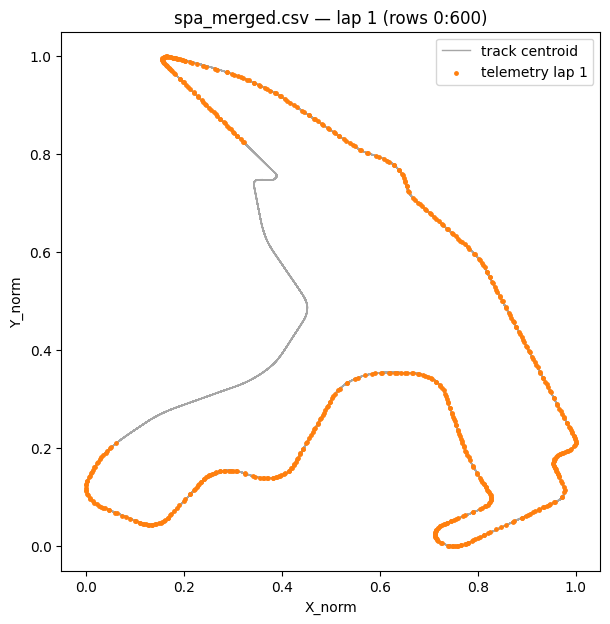

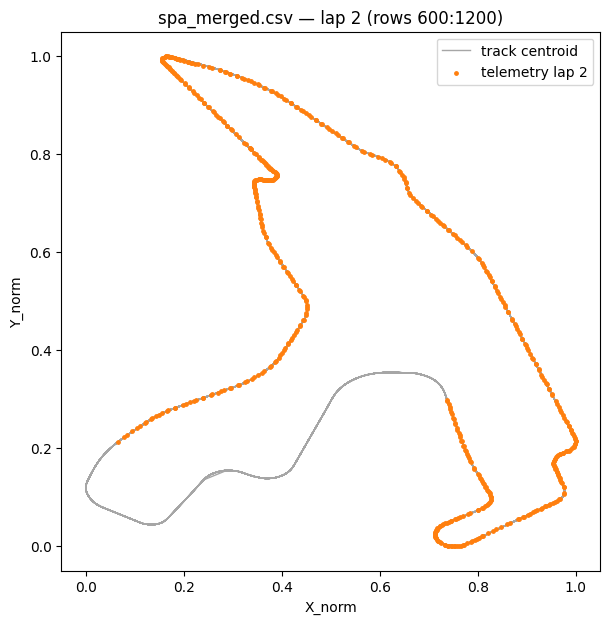

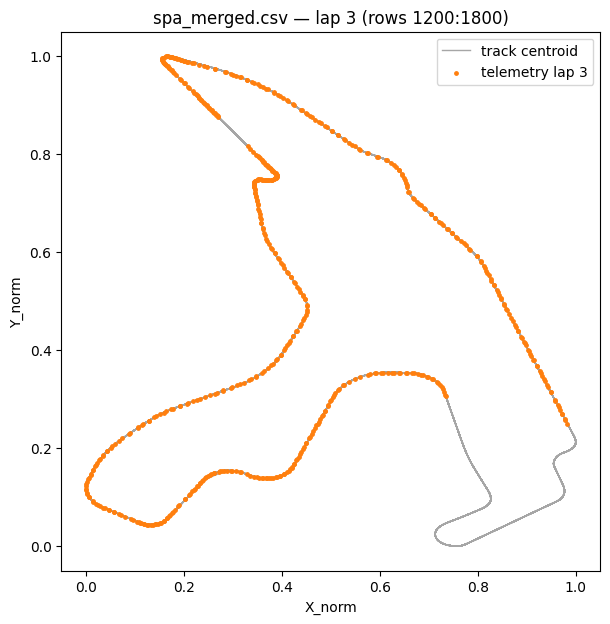


File: monza_merged.csv rows=10159 approximate_laps=16 using normalized coords


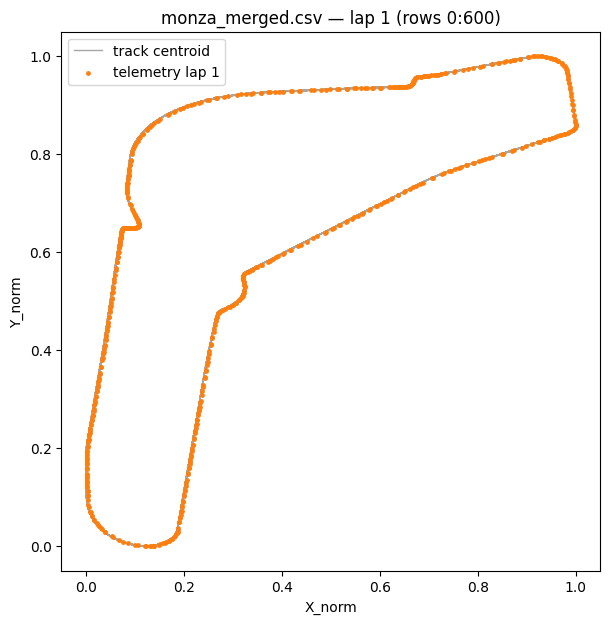

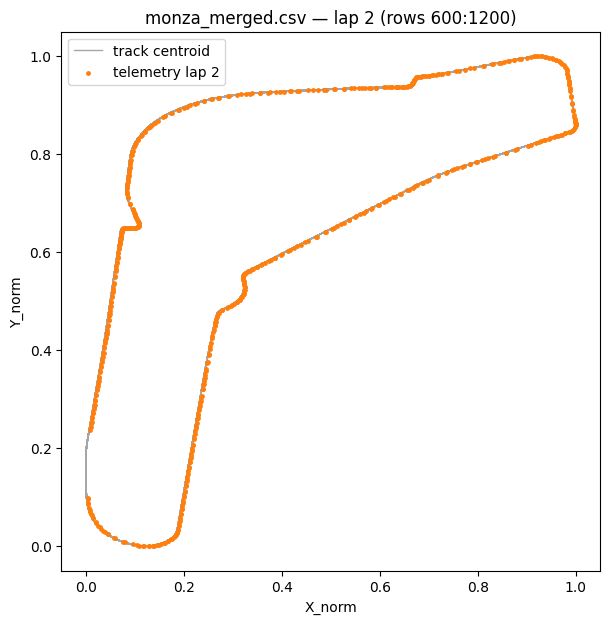

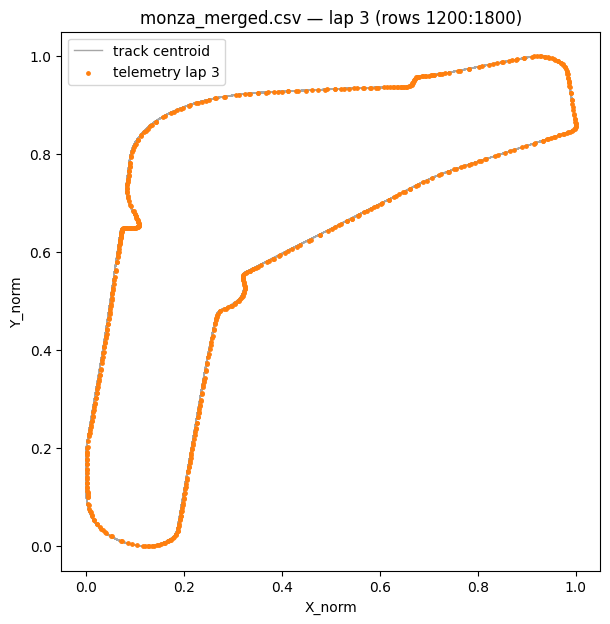


File: budapest_merged.csv rows=9719 approximate_laps=16 using normalized coords


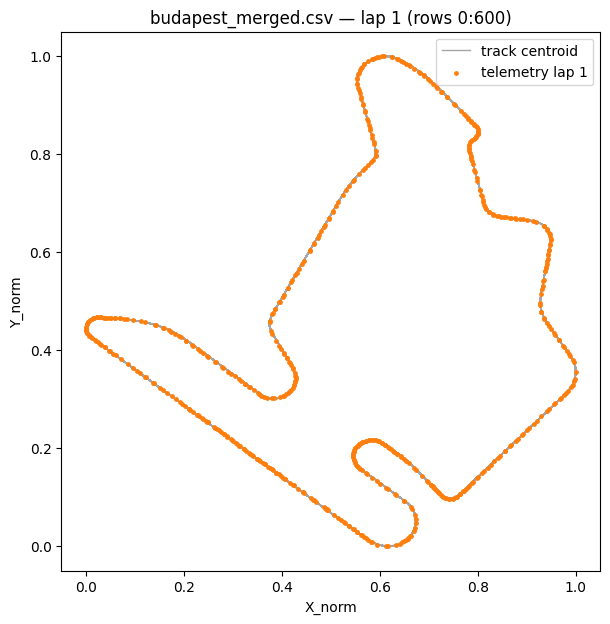

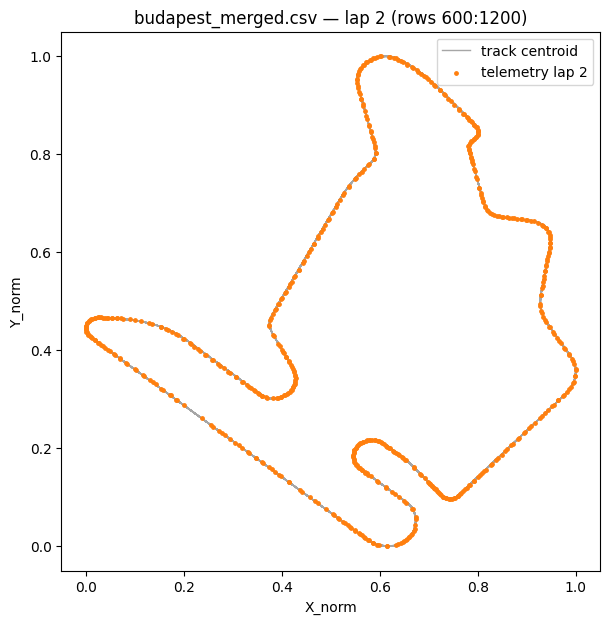

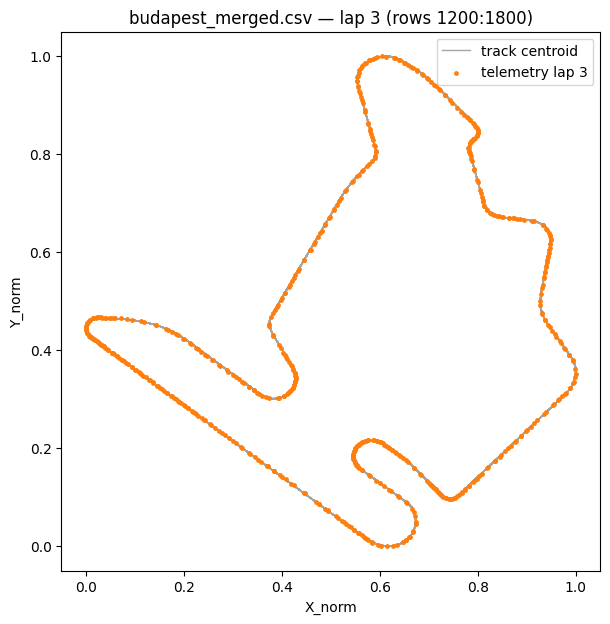

In [5]:
# Visualization: plot merged telemetry over track centroid for sample laps (600 rows per lap)
# Uses normalized coords if present (X_norm/Y_norm and trk_centroid_x_norm/trk_centroid_y_norm)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

files = [Path('NewData/spa_merged.csv'), Path('NewData/monza_merged.csv'), Path('NewData/budapest_merged.csv')]

for f in files:
    if not f.exists():
        print(f"{f} not found, skipping")
        continue
    df = pd.read_csv(f)
    nrows = len(df)
    laps = nrows // 600
    use_norm = {'X_norm','Y_norm','trk_centroid_x_norm','trk_centroid_y_norm'}.issubset(df.columns)
    if use_norm:
        tx, ty = 'X_norm','Y_norm'
        trk_x, trk_y = 'trk_centroid_x_norm','trk_centroid_y_norm'
        coord_space = 'normalized'
    else:
        tx, ty = 'X','Y'
        trk_x, trk_y = 'trk_x_m','trk_y_m'
        coord_space = 'metres'

    print(f"\nFile: {f.name} rows={nrows} approximate_laps={laps} using {coord_space} coords")

    max_plot = min(laps if laps>0 else 1, 3)
    for lap in range(max_plot):
        s = lap*600
        e = min((lap+1)*600, nrows)
        sub = df.iloc[s:e]
        plt.figure(figsize=(7,7))
        if trk_x in df.columns and trk_y in df.columns:
            plt.plot(df[trk_x], df[trk_y], color='gray', linewidth=1, alpha=0.7, label='track centroid')
        plt.scatter(sub[tx], sub[ty], s=6, c='C1', label=f'telemetry lap {lap+1}', zorder=3)
        plt.gca().set_aspect('equal', 'box')
        plt.title(f"{f.name} — lap {lap+1} (rows {s}:{e})")
        plt.xlabel(tx)
        plt.ylabel(ty)
        plt.legend()
        plt.show()